<a href="https://colab.research.google.com/github/inuwamobarak/nougat/blob/main/Nougat_Inference_to_read_scientific_PDFs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is strongly inspired by the HF TF boss, Niels Rogge: https://github.com/NielsRogge/Transformers-Tutorials/tree/master/Nougat

#Step 1: Set-Up Environment

In [1]:
!pip install -q pymupdf python-Levenshtein nltk
!pip install -q git+https://github.com/huggingface/transformers.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 106.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 21.2 MB/s eta 0:00:00


#Step 2: Load Model and Processor

In [2]:
from transformers import AutoProcessor, VisionEncoderDecoderModel
import torch

# Load the Nougat model and processor from the hub
processor = AutoProcessor.from_pretrained("facebook/nougat-small")
model = VisionEncoderDecoderModel.from_pretrained("facebook/nougat-small")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
%%capture
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

In [4]:
from typing import Optional, List
import io
import fitz
from pathlib import Path

def rasterize_paper(
    pdf: Path,
    outpath: Optional[Path] = None,
    dpi: int = 96,
    return_pil=False,
    pages=None,
) -> Optional[List[io.BytesIO]]:
    """
    Rasterize a PDF file to PNG images.

    Args:
        pdf (Path): The path to the PDF file.
        outpath (Optional[Path], optional): The output directory. If None, the PIL images will be returned instead. Defaults to None.
        dpi (int, optional): The output DPI. Defaults to 96.
        return_pil (bool, optional): Whether to return the PIL images instead of writing them to disk. Defaults to False.
        pages (Optional[List[int]], optional): The pages to rasterize. If None, all pages will be rasterized. Defaults to None.

    Returns:
        Optional[List[io.BytesIO]]: The PIL images if `return_pil` is True, otherwise None.
    """

    pillow_images = []
    if outpath is None:
        return_pil = True
    try:
        if isinstance(pdf, (str, Path)):
            pdf = fitz.open(pdf)
        if pages is None:
            pages = range(len(pdf))
        for i in pages:
            page_bytes: bytes = pdf[i].get_pixmap(dpi=dpi).pil_tobytes(format="PNG")
            if return_pil:
                pillow_images.append(io.BytesIO(page_bytes))
            else:
                with (outpath / ("%02d.png" % (i + 1))).open("wb") as f:
                    f.write(page_bytes)
    except Exception:
        pass
    if return_pil:
        return pillow_images

#Step 3: Load PDF

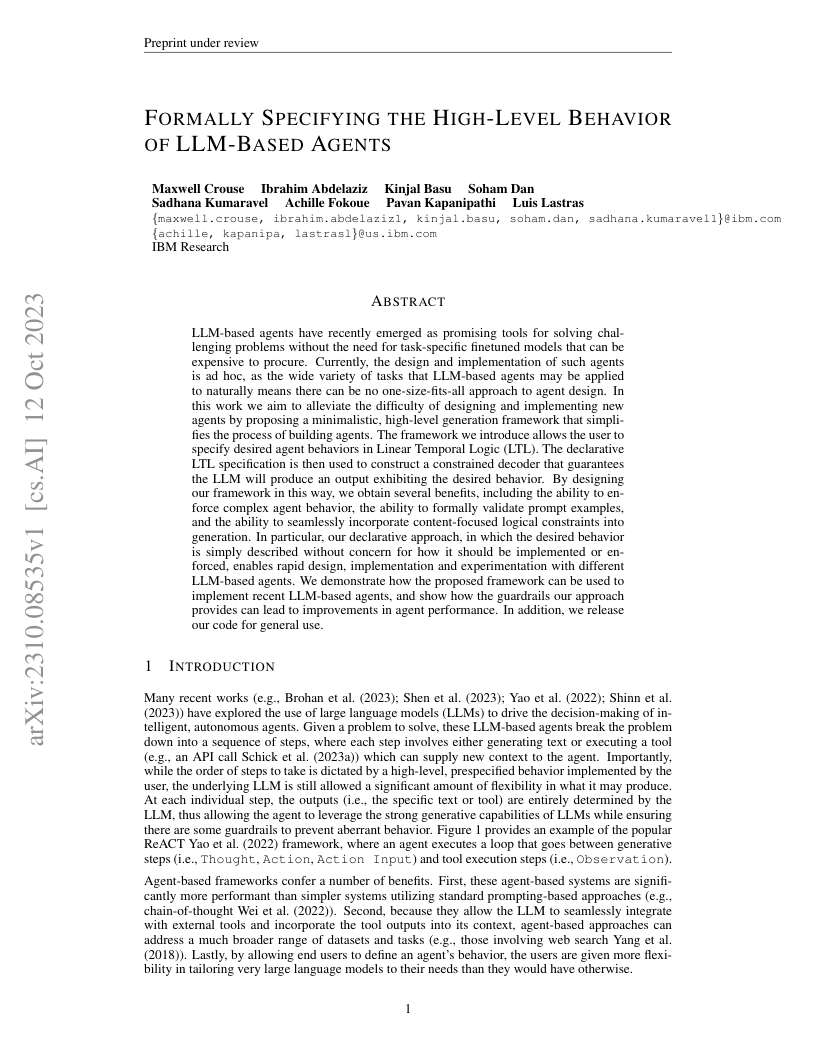

In [9]:
from huggingface_hub import hf_hub_download
from typing import Optional, List
import io
import fitz
from pathlib import Path
from PIL import Image

filepath = hf_hub_download(repo_id="inuwamobarak/random-files", filename="2310.08535.pdf", repo_type="dataset")

images = rasterize_paper(pdf=filepath, return_pil=True)
image = Image.open(images[0])
image

#Step 4: Generate Transcription

In [10]:
pixel_values = processor(images=image, return_tensors="pt").pixel_values

In [11]:
from transformers import StoppingCriteria, StoppingCriteriaList
from collections import defaultdict

class RunningVarTorch:
    def __init__(self, L=15, norm=False):
        self.values = None
        self.L = L
        self.norm = norm

    def push(self, x: torch.Tensor):
        assert x.dim() == 1
        if self.values is None:
            self.values = x[:, None]
        elif self.values.shape[1] < self.L:
            self.values = torch.cat((self.values, x[:, None]), 1)
        else:
            self.values = torch.cat((self.values[:, 1:], x[:, None]), 1)

    def variance(self):
        if self.values is None:
            return
        if self.norm:
            return torch.var(self.values, 1) / self.values.shape[1]
        else:
            return torch.var(self.values, 1)


class StoppingCriteriaScores(StoppingCriteria):
    def __init__(self, threshold: float = 0.015, window_size: int = 200):
        super().__init__()
        self.threshold = threshold
        self.vars = RunningVarTorch(norm=True)
        self.varvars = RunningVarTorch(L=window_size)
        self.stop_inds = defaultdict(int)
        self.stopped = defaultdict(bool)
        self.size = 0
        self.window_size = window_size

    @torch.no_grad()
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        last_scores = scores[-1]
        self.vars.push(last_scores.max(1)[0].float().cpu())
        self.varvars.push(self.vars.variance())
        self.size += 1
        if self.size < self.window_size:
            return False

        varvar = self.varvars.variance()
        for b in range(len(last_scores)):
            if varvar[b] < self.threshold:
                if self.stop_inds[b] > 0 and not self.stopped[b]:
                    self.stopped[b] = self.stop_inds[b] >= self.size
                else:
                    self.stop_inds[b] = int(
                        min(max(self.size, 1) * 1.15 + 150 + self.window_size, 4095)
                    )
            else:
                self.stop_inds[b] = 0
                self.stopped[b] = False
        return all(self.stopped.values()) and len(self.stopped) > 0

In [12]:
outputs = model.generate(
    pixel_values.to(device),
    min_length=1,
    max_length=3584,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
    output_scores=True,
    stopping_criteria=StoppingCriteriaList([StoppingCriteriaScores()]),
)

# Step 5: Postprocess

In [13]:
generated = processor.batch_decode(outputs[0], skip_special_tokens=True)[0]

generated = processor.post_process_generation(generated, fix_markdown=False)
print(generated)



# Formally Specifying the High-Level Behavior

of LLM-Based Agents

Maxwell Crouse Ibrahim Abdelaziz Kinjal Basu Soham Dan

Sadhana Kumarvel Achille Fokoue Pavan Kapanipathi Luis Lastras

{maxwell.crouse, ibrahim.abdelazzi, kinjal.basu, soham.dan, sadhana.kumaravell}@ibm.com

{achille, kapanipa, lastrasl}@us.ibm.com

IBM Research

###### Abstract

LLM-based agents have recently emerged as promising tools for solving challenging problems without the need for task-specific finetuned models that can be expensive to procure. Currently, the design and implementation of such agents is ad hoc, as the wide variety of tasks that LLM-based agents may be applied to naturally means there can be no one-size-fits-all approach to agent design. In this work we aim to alleviate the difficulty of designing and implementing new agents by proposing a minimalistic, high-level generation framework that simplifies the process of building agents. The framework we introduce allows the user to specify desired

**Links:**

https://github.com/NielsRogge/Transformers-Tutorials/

https://github.com/inuwamobarak/nougat

https://arxiv.org/abs/2310.08535

https://arxiv.org/pdf/2308.13418.pdf

https://huggingface.co/datasets/inuwamobarak/random-files

https://huggingface.co/spaces/ysharma/nougat